In [1]:
%load_ext lab_black
# load pretty jupyter's magics
%load_ext pretty_jupyter

In [2]:
# Please import here all the necessary libraries
import pandas as pd
import csv

# import io
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# plt.rcParams["figure.figsize"] = (20,7)
from math import sqrt
from tqdm import tqdm
import plotly.graph_objects as go
import chart_studio.plotly as py
import os
import datacube
from scipy.stats import loguniform, uniform
from matplotlib.pyplot import figure
import geopandas as gpd
import openpyxl
import math
from itertools import combinations
import ipywidgets as widgets
from shapely.geometry import Polygon

# import plotly.express as px
import rioxarray as rio
from plotly.subplots import make_subplots
import joblib


# ML
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, SplineTransformer

# import torch
# import torch.nn as nn
# from torch.autograd import Variable
from tensorflow import keras

# from keras_tuner.tuners import BayesianOptimization
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    VotingRegressor,
    StackingRegressor,
)
from sklearn.svm import SVR
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    RationalQuadratic,
    CompoundKernel,
    WhiteKernel,
)
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

# Feature Selection
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeCV
from joblib import dump, load

import tensorflow as tf

# from tensorflow.keras import datasets, layers, models

# Hide Warnings
import warnings

warnings.filterwarnings("ignore")

# Functions

### Scaling

In [3]:
def scale_data(train_data, test_data):
    # Define scalers, f is for all features, t is for the 'y' we want to predict
    # We have two different scalers because we only want to scale features without considering the result
    # Also we are not scaling with the testing data, to avoid leakage from testing to training data
    f_transformer = MinMaxScaler()
    t_transformer = MinMaxScaler()
    # Fit scalers
    f_transformer = f_transformer.fit(train_data[:, 1:])
    t_transformer = t_transformer.fit((train_data[:, 0]).reshape(len(train_data), 1))
    # here we scale the X training data with its transformer
    train_data_X = f_transformer.transform(train_data[:, 1:])
    # here we scale the Y training data with its transformer. We reshape twice to first scale and then insert that
    # data into the original array
    train_data_y = (
        t_transformer.transform((train_data[:, 0]).reshape(len(train_data), 1))
    ).reshape(len(train_data), 1)
    # here we scale testing data with the training scalers
    test_data_X = f_transformer.transform(test_data[:, 1:])
    test_data_y = t_transformer.transform(
        (test_data[:, 0]).reshape(len(test_data), 1)
    ).reshape(len(test_data), 1)
    # here we create the new tran and test datasets
    train_data = np.concatenate((train_data_y, train_data_X), axis=1)
    test_data = np.concatenate((test_data_y, test_data_X), axis=1)
    return (
        f_transformer,
        t_transformer,
        train_data,
        test_data,
        train_data_X,
        train_data_y,
        test_data_X,
        test_data_y,
    )

### Plot

In [4]:
def plot_estimations_sensors(
    test_df, inv_yhat_RF, row, col, sensor, remove_background=False
):
    legend = dict(
        yanchor="top",
        y=0.95,
        xanchor="right",
        x=0.9,
        traceorder="normal",
        bgcolor="white",
        borderwidth=1,
        bordercolor="gray",
        font=dict(
            size=11,
        ),
    )
    forecast_line = dict(color="#fc5203", width=2)
    true_line = dict(color="#2790db", width=2)
    df_forecasted = test_df[["ground_no2", "satellite_no2"]]
    df_forecasted.insert(2, "pred", inv_yhat_RF)

    fig.add_trace(
        go.Scatter(
            y=df_forecasted["ground_no2"],
            x=df_forecasted.index,
            connectgaps=False,
            name="True ground NO2",
            line=true_line,
        ),
        row=row,
        col=col,
    )
    fig.add_trace(
        go.Scatter(
            y=df_forecasted["pred"],
            x=df_forecasted.index,
            connectgaps=False,
            name="Estimation ground NO2",
            line=forecast_line,
        ),
        row=row,
        col=col,
    )
    # fig.update_traces(connectgaps=False)
    # fig.update_layout(legend=legend)
    fig.update_xaxes(
        title_text="Date",
        showgrid=True,
        gridwidth=1,
        gridcolor="LightGray",
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="gray",
    )
    fig.update_yaxes(
        title_text="NO<sub>2</sub> [ug/m<sup>3</sup>]",
        showgrid=True,
        gridwidth=1,
        gridcolor="LightGray",
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="gray",
    )
    fig.update_xaxes(rangebreaks=[dict(bounds=["2022-08-09", "2022-08-23"])])
    fig.update_layout(title=go.layout.Title(text="Sensor: " + str(sensor)))
    if remove_background:
        fig.update_layout(paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
    # fig.show()

# NO$_2$ Sensor Testing (random dates)

In [5]:
df_complete = pd.read_csv(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/milano-df_complete-2024_05_30.csv",
    index_col="date",
)
df_complete

Unnamed: 0  idsensore  \
date                                
2019-01-01           0       5504   
2019-01-02           1       5504   
2019-01-07           2       5504   
2019-01-09           3       5504   
2019-01-10           4       5504   
...                ...        ...   
2023-03-19        9354       5609   
2023-03-20        9355       5609   
2023-03-21        9356       5609   
2023-03-22        9357       5609   
2023-03-23        9358       5609   

                                                geometry  ground_no2  \
date                                                                   
2019-01-01  POINT (1023130.0432923241 5699997.723437063)      48.175   
2019-01-02  POINT (1023130.0432923241 5699997.723437063)      19.925   
2019-01-07  POINT (1023130.0432923241 5699997.723437063)      87.500   
2019-01-09  POINT (1023130.0432923241 5699997.723437063)      31.475   
2019-01-10  POINT (1023130.0432923241 5699997.723437063)      80.300   
...                                                  ...         ...   
2023-03-19  POINT (1033345.4455977813 5684111.372675919)      20.900   
2023-03-20  POINT (1033345.4455977813 5684111.372675919)      24.300   
2023-03-21  POINT (1033345.4455977813 5684111.372675919)      29.750   
2023-03-22  POINT (1033345.4455977813 5684111.372675919)      29.050   
2023-03-23  POINT (1033345.4455977813 5684111.372675919)      23.075   

            satellite_no2  curr_temp_celsius  \
date                                           
2019-01-01       0.000177           6.284843   
2019-01-02       0.000060          10.332783   
2019-01-07       0.000301           9.018296   
2019-01-09       0.000059           8.670173   
2019-01-10       0.000365           9.219039   
...                   ...                ...   
2023-03-19       0.000088          16.249579   
2023-03-20       0.000084          16.284165   
2023-03-21       0.000153          18.790216   
2023-03-22       0.000150          20.311439   
2023-03-23       0.000093          19.437774   

            curr_surface_net_solar_radiation  \
date                                           
2019-01-01                         848791.20   
2019-01-02                         998093.25   
2019-01-07                         998709.70   
2019-01-09                         909195.75   
2019-01-10                        1055114.50   
...                                      ...   
2023-03-19                        1120547.10   
2023-03-20                        1166383.00   
2023-03-21                        1963986.90   
2023-03-22                        2079550.60   
2023-03-23                        2009759.50   

            curr_surface_net_thermal_radiation  curr_surface_pressure  \
date                                                                    
2019-01-01                          -317097.40             101059.840   
2019-01-02                          -452136.20             100492.400   
2019-01-07                          -405108.97             100956.090   
2019-01-09                          -386017.16              99039.840   
2019-01-10                          -449154.84              99624.984   
...                                        ...                    ...   
2023-03-19                          -242825.00             100239.730   
2023-03-20                          -228225.77             100237.960   
2023-03-21                          -456331.94             100029.490   
2023-03-22                          -492861.62              99863.300   
2023-03-23                          -438223.40              99864.695   

            curr_total_precipitation  ...  curr_boundary_layer_height  \
date                                  ...                               
2019-01-01              9.503371e-07  ...                   313.80615   
2019-01-02              0.000000e+00  ...                  1501.84830   
2019-01-07              0.000000e+00  ...                   297.52786   
2019-01-09              0.00

In [6]:
df_complete = pd.read_csv(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/milano-df_complete-2024_05_30.csv",
    index_col="date",
)

df_complete = df_complete[
    [
        "ground_no2",
        "idsensore",
        "satellite_no2",
        "curr_temp_celsius",
        "curr_surface_net_solar_radiation",
        "curr_surface_pressure",
        "prev_temp_celsius",
        "prev_surface_net_solar_radiation",
    ]
]

best_mod = joblib.load(
    "./models_export/2023_10-13_rmse_best_mod_all_stations_separate_random_split.joblib"
)

In [7]:
df_complete

ground_no2  idsensore  satellite_no2  curr_temp_celsius  \
date                                                                  
2019-01-01      48.175       5504       0.000177           6.284843   
2019-01-02      19.925       5504       0.000060          10.332783   
2019-01-07      87.500       5504       0.000301           9.018296   
2019-01-09      31.475       5504       0.000059           8.670173   
2019-01-10      80.300       5504       0.000365           9.219039   
...                ...        ...            ...                ...   
2023-03-19      20.900       5609       0.000088          16.249579   
2023-03-20      24.300       5609       0.000084          16.284165   
2023-03-21      29.750       5609       0.000153          18.790216   
2023-03-22      29.050       5609       0.000150          20.311439   
2023-03-23      23.075       5609       0.000093          19.437774   

            curr_surface_net_solar_radiation  curr_surface_pressure  \
date                                                                  
2019-01-01                         848791.20             101059.840   
2019-01-02                         998093.25             100492.400   
2019-01-07                         998709.70             100956.090   
2019-01-09                         909195.75              99039.840   
2019-01-10                        1055114.50              99624.984   
...                                      ...                    ...   
2023-03-19                        1120547.10             100239.730   
2023-03-20                        1166383.00             100237.960   
2023-03-21                        1963986.90             100029.490   
2023-03-22                        2079550.60              99863.300   
2023-03-23                        2009759.50              99864.695   

            prev_temp_celsius  prev_surface_net_solar_radiation  
date                                                             
2019-01-01           2.339170                        114024.984  
2019-01-02           4.752379                        138727.270  
2019-01-07           2.107214                        143625.720  
2019-01-09           3.089382                        140911.380  
2019-01-10           2.583570                        153967.280  
...                       ...                               ...  
2023-03-19          11.763362                        319966.780  
2023-03-20          11.524860                        350664.100  
2023-03-21          12.049205                        435305.300  
2023-03-22          13.790619                        464204.000  
2023-03-23          13.323330                        362500.000  

[9359 rows x 8 columns]

In [8]:
# -------------- Divide in Train/Test --------------

# Lists to store the data
train_dates = []
test_dates = []

# Open the CSV training_dates file in read mode
with open(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/train_dates-original.csv",
    "r",
    newline="",
) as file:
    reader = csv.reader(file)

    # Iterate over each row in the CSV file and append to the list
    for row in reader:
        if row:  # Make sure the row is not empty
            train_dates.append(row[1])

# Open the CSV testing_dates file in read mode
with open(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/test_dates-original.csv",
    "r",
    newline="",
) as file:
    reader = csv.reader(file)

    # Iterate over each row in the CSV file and append to the list
    for row in reader:
        if row:  # Make sure the row is not empty
            test_dates.append(row[1])

train = df_complete[df_complete.index.isin(train_dates)]
test = df_complete[df_complete.index.isin(test_dates)]

train_X = train.iloc[:, 1:]
test_X = test.iloc[:, 1:]
train_y = train.iloc[:, 0:2]
test_y = test.iloc[:, 0:2]

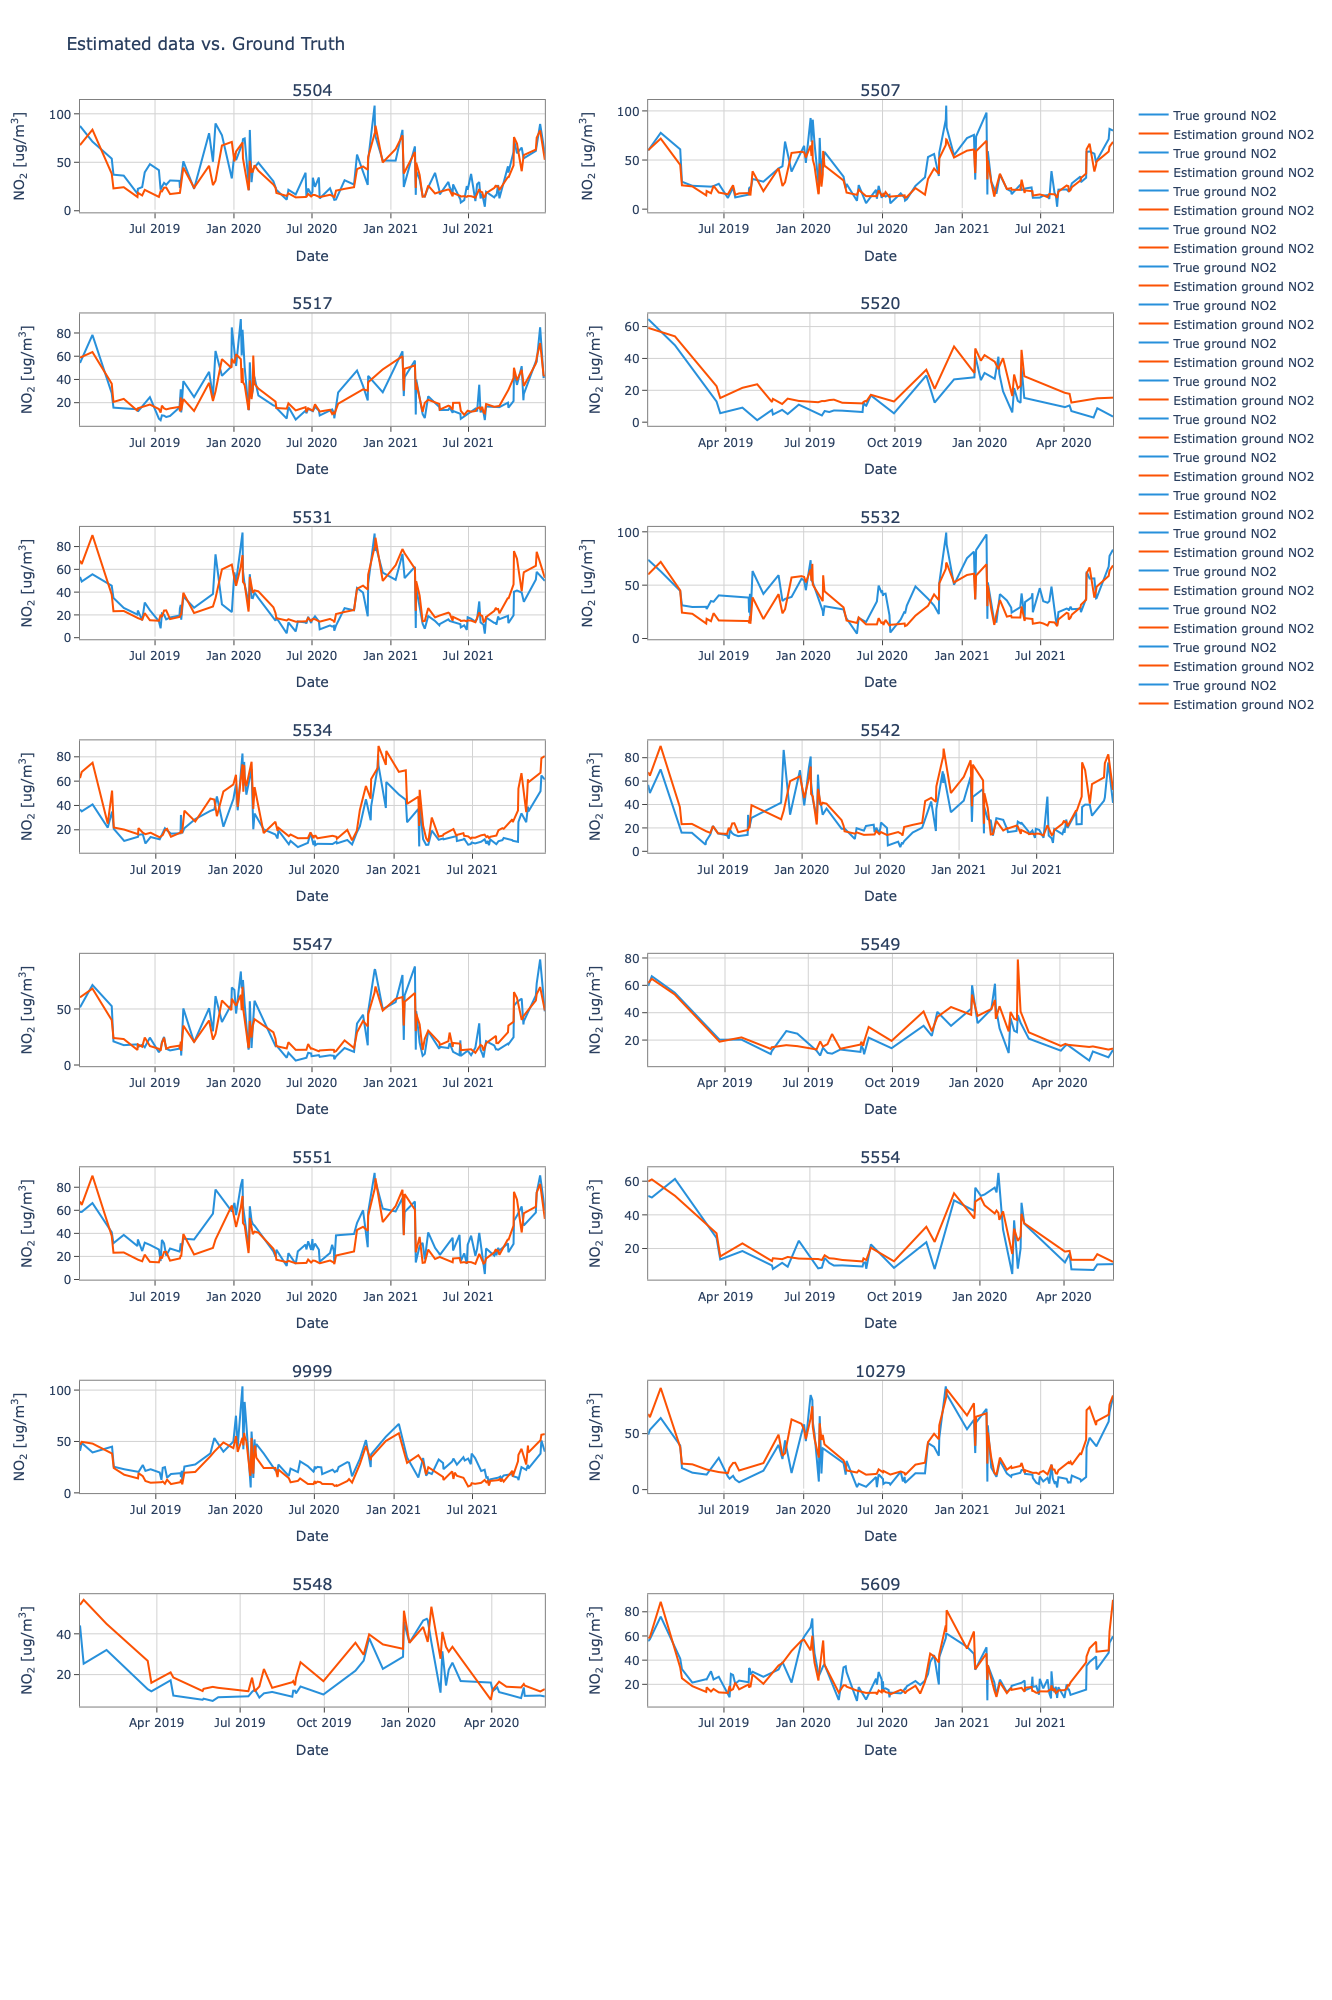

In [9]:
sensors_list = df_complete["idsensore"].unique()
sensors_list_str = [str(x) for x in sensors_list]
sensors_df = pd.DataFrame(columns=["sensor", "NRMSE", "RMSE", "Corr", "St_Dev"])
fig = go.Figure()
column = 1
row = 1
fig = make_subplots(
    cols=2, rows=int(len(sensors_list) / 2) + 1, subplot_titles=(sensors_list_str)
)

(
    f_trans,
    t_trans,
    s_train_data,
    s_test_data,
    s_train_X,
    s_train_y,
    s_test_X,
    s_test_y,
) = scale_data(
    train[train.drop(columns="idsensore").columns].values,
    test[test.drop(columns="idsensore").columns].values,
)

for sensor in sensors_list:
    train_X_sensor = train_X[train_X["idsensore"] == sensor]
    test_X_sensor = test_X[test_X["idsensore"] == sensor]
    train_y_sensor = train_y[train_y["idsensore"] == sensor]
    test_y_sensor = test_y[test_y["idsensore"] == sensor]

    train_X_sensor.drop(["idsensore"], axis=1, inplace=True)
    test_X_sensor.drop(["idsensore"], axis=1, inplace=True)
    train_y_sensor.drop(["idsensore"], axis=1, inplace=True)
    test_y_sensor.drop(["idsensore"], axis=1, inplace=True)

    train_X_sensor.sort_index(inplace=True)
    test_X_sensor.sort_index(inplace=True)
    train_y_sensor.sort_index(inplace=True)
    test_y_sensor.sort_index(inplace=True)

    train_sensor = pd.concat(
        [train_y_sensor, train_X_sensor], axis=1, ignore_index=False
    )
    test_sensor = pd.concat([test_y_sensor, test_X_sensor], axis=1, ignore_index=False)
    test_dates = test_sensor.index

    if len(test_sensor) != 0:
        # -------------- Normalize Data --------------
        s_test_X = f_trans.transform(test_X_sensor)
        s_test_y = t_trans.transform(test_y_sensor)

        s_test_X = s_test_X.reshape(s_test_X.shape[0], 1, s_test_X.shape[1])
        s_test_y = s_test_y.reshape(s_test_y.shape[0], 1, s_test_y.shape[1])
        # -------------- Test --------------
        yhat_bst = best_mod.predict(
            s_test_X.reshape(s_test_X.shape[0], s_test_X.shape[2])
        )
        # invert scaling for forecast
        inv_yhat_bst = t_trans.inverse_transform(yhat_bst.reshape(yhat_bst.shape[0], 1))
        # calculate RMSE
        mae = mean_absolute_error(test_y_sensor, inv_yhat_bst)
        rmse_bst = sqrt(mean_squared_error(test_y_sensor, inv_yhat_bst))
        rl_df = pd.DataFrame(t_trans.inverse_transform(s_test_y[:, 0]))
        rl_df = rl_df.rename(columns={0: "pred"})
        rl_df["dates"] = test_dates
        bst_df = pd.DataFrame(inv_yhat_bst)
        nrmse = rmse_bst / test_y_sensor.std()
        p_coef = np.corrcoef(
            test_y_sensor.values.reshape(
                len(test_y_sensor),
            ),
            inv_yhat_bst.reshape(
                len(inv_yhat_bst),
            ),
        )[0][1]

        residuals = test_y_sensor - inv_yhat_bst.reshape(test_y_sensor.shape)
        residuals_df = pd.DataFrame(residuals, columns=["residual"])
        residuals_df.set_index(rl_df["dates"], inplace=True)
        res_mean = residuals_df.mean().values[0]
        res_std = residuals_df.std().values[0]
        sqm_3_df = residuals_df[residuals_df["residual"] > 3 * res_std]
        sqm_3_str = ",".join(sqm_3_df["residual"].astype(str).tolist())

        # -------------- Add data to dataframe --------------
        sens_row = {
            "sensor": [sensor],
            "NRMSE": [nrmse[0]],
            "RMSE": [rmse_bst],
            "Corr": [p_coef],
            "St_Dev": [test_y_sensor.std()[0]],
            "Data Size": [len(test_y_sensor)],
            "Rsd mean": [res_mean],
            "Rsd std": [res_std],
            "sqm 3": [sqm_3_str],
        }
        sens_row = pd.DataFrame(sens_row)
        sensors_df = pd.concat([sensors_df, sens_row])
        # -------------- Plot --------------
        if column % 2 == 1:
            plot_estimations_sensors(
                test_sensor, inv_yhat_bst, row, column, sensor, True
            )
            column += 1
        else:
            # row=plot_row+1
            plot_estimations_sensors(
                test_sensor, inv_yhat_bst, row, column, sensor, True
            )
            column -= 1
            row += 1

        # plot_row += 1

    else:
        pass

sensors_df.reset_index(inplace=True, drop=True)
fig.update_layout(height=2000, title_text="Estimated data vs. Ground Truth")
fig.show()

In [10]:
sqm_3_df

Empty DataFrame
Columns: [residual]
Index: []

In [11]:
sensors_df.sort_values(by="sensor")

sensor     NRMSE       RMSE      Corr     St_Dev  Data Size  Rsd mean  \
0    5504  0.578830  13.275680  0.838853  22.935381      115.0       NaN   
1    5507  0.472046  11.710681  0.913044  24.808324      115.0       NaN   
2    5517  0.516716  10.874598  0.860653  21.045596      110.0       NaN   
3    5520  0.689587   9.478141  0.911150  13.744659       46.0       NaN   
4    5531  0.596732  11.946509  0.848539  20.019873      118.0       NaN   
5    5532  0.772423  15.575857  0.773861  20.164923      104.0       NaN   
6    5534  0.655011  12.600376  0.908316  19.236882      112.0       NaN   
7    5542  0.699307  12.698904  0.825021  18.159265      117.0       NaN   
8    5547  0.431021  10.409763  0.917831  24.151388      111.0       NaN   
14   5548  0.754331   9.205437  0.847057  12.203441       51.0       NaN   
9    5549  0.572420   9.339347  0.861515  16.315550       46.0       NaN   
10   5551  0.608065  11.906601  0.868028  19.581146      115.0       NaN   
11   5554  0.437521   8.417527  0.909784  19.239143       47.0       NaN   
15   5609  0.592950   9.413133  0.859852  15.875076      115.0       NaN   
12   9999  0.806474  13.133559  0.743129  16.285160      115.0       NaN   
13  10279  0.539758  12.797300  0.904507  23.709340      104.0       NaN   

    Rsd std sqm 3  
0       NaN        
1       NaN        
2       NaN        
3       NaN        
4       NaN        
5       NaN        
6       NaN        
7       NaN        
8       NaN        
14      NaN        
9       NaN        
10      NaN        
11      NaN        
15      NaN        
12      NaN        
13      NaN

In [13]:
sensors_df["Corr"].mean()

0.8619462768836488

In [12]:
sensors_df = sensors_df.sort_values(by="sensor")
print("Mean NRMSE: " + str(sensors_df["NRMSE"].mean()))
print("Median NRMSE: " + str(sensors_df["NRMSE"].median()))
print(
    "Number of stations with RMSE below 1: "
    + str(len(sensors_df[sensors_df["NRMSE"] < 1]))
    + "/"
    + str(len(sensors_df["NRMSE"]))
)

Mean NRMSE: 0.6076996319035538
Median NRMSE: 0.5948414524731443
Number of stations with RMSE below 1: 16/16


# General Statistics

In [ ]:
from scipy import stats

In [ ]:
pear_coef = np.corrcoef(test_y, inv_yhat_bst.reshape(len(inv_yhat_bst), ))[0]
spear_coef = stats.spearmanr(test_y, inv_yhat_bst.reshape(len(inv_yhat_bst), ))[0]
kendall_coef = stats.kendalltau(test_y, inv_yhat_bst.reshape(len(inv_yhat_bst), ))[0]
print('Pearson Corr between estimation and real data: %.2f' %pear_coef[1] + '\n' + 
      'Spearman Corr between estimation and real data: %.2f' %spear_coef + '\n' + 
      'Kendall Corr between estimation and real data: %.2f' %kendall_coef)

In [ ]:
len(test_y)

In [ ]:
print('Data mean: '+ str(df_complete['ground_no2'].mean()))
print('Data median: '+ str(df_complete['ground_no2'].median()))
print('Data min: '+ str(df_complete['ground_no2'].min()))
print('Data max: '+ str(df_complete['ground_no2'].max()))
print('Data std. dev.: '+ str(df_complete['ground_no2'].std()))

In [ ]:
print('Test Mean: %.3f' %test_y.mean() + '\n' + 
      'Test Max: %.3f' %test_y.max()+ '\n' + 
      'Test Min: %.3f' %test_y.min()+ '\n' + 
      'Test St.Dev.: %.3f' %test_y.std()+ '\n' + '\n'
      'Best model mean.: %.3f' %inv_yhat_bst.mean()+ '\n' + 
      'Best model St.Dev.: %.3f' %inv_yhat_bst.std()+ '\n'+
      'Best model min.: %.3f' %inv_yhat_bst.min()+ '\n'+  
      'Best model max.: %.3f' %inv_yhat_bst.max()+ '\n')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_y, y=train_y, mode="markers"))
#trace = go.Histogram(
 #   x=df_complete['ground_no2'][df_complete.index < '2022-03-07']
#)
fig.show()

## Peaks Analysis

In [ ]:
df_complete[df_complete.index == '2022-03-24']

In [ ]:
from plotly.subplots import make_subplots
# specify columns to plot
i = 1
j = 1
# plot each column
fig = make_subplots(rows=len(df_train_normalized.columns), cols=1)


for column in df_train_graph.columns:
  if column != 'index':
    fig.add_trace(
      go.Scatter(y=(df_complete[column][(df_complete.index >'2022-03-15')&(df_complete.index <'2022-04-10')]), x=(df_complete.index[(df_complete.index>'2022-03-15')&(df_complete.index <'2022-04-10')]), name = column),
      row=j, col=1
    )
    j += 1
fig.update_layout(height=1500, title_text="Normalized data vs. Original data")
fig.show()